# Восстановление золота из руды

**Задача:** Исследоваьт процесс очистки золота и обучить модель предсказывать коэффициент восстановления золота из золотосодержащей руды.

Метрика sMAPE

**План проекта:**

1. Подготовка данных
    - Общая информация
    - Эффективность обогащения
    - Признаки
    - Предобработка данных
2. Анализ данных
    - Изменение концентрации металлов
    - Размеры гранул
    - Суммарная концентрация металлов
3. Обучение модели
    - Признаки для обучения моделей
    - Обучение — Rougher
    - Обучение — Final
    - Проверка лучшей модели

**Наименование признаков**

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyRegressor

### Общая информация

In [2]:
# выгрузим и посмотрим файлы
try:
    train = pd.read_csv('/datasets/gold_industry_train.csv', index_col=['date'])
except:
    train = pd.read_csv('/datasets/gold_industry_train.csv', index_col=['date'])

train.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               14579 non-null  float64
 1   rougher.input.feed_ag                               14579 non-null  float64
 2   rougher.input.feed_pb                               14507 non-null  float64
 3   rougher.input.feed_sol                              14502 non-null  float64
 4   rougher.input.feed_rate                             14572 non-null  float64
 5   rougher.input.feed_size                             14478 non-null  float64
 6   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 7   rougher.input.floatbank10_xanthate                  14572 non-null  float64
 8   rougher.state.floatbank10_a_air                  

In [4]:
train.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


In [5]:
try:
    test = pd.read_csv('/datasets/gold_industry_test.csv', index_col=['date'])
except:
    test = pd.read_csv('/datasets/gold_industry_test.csv', index_col=['date'])

test.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,-299.862743,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,-299.907308,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,-300.124116,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,-299.778385,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,-300.283401,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   rougher.state.floatbank10_a_level           4859 non-null

In [7]:
test.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


In [8]:
try:
    full_data = pd.read_csv('/datasets/gold_industry_full.csv', index_col=['date'])
except:
    full_data = pd.read_csv('/datasets/gold_industry_full.csv', 
                            index_col=['date'])

full_data.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,-404.066986,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,-400.065196,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,-400.074028,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,-400.200179,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,-399.752729,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [9]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               19439 non-null  float64
 1   rougher.input.feed_ag                               19439 non-null  float64
 2   rougher.input.feed_pb                               19339 non-null  float64
 3   rougher.input.feed_sol                              19340 non-null  float64
 4   rougher.input.feed_rate                             19428 non-null  float64
 5   rougher.input.feed_size                             19294 non-null  float64
 6   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 7   rougher.input.floatbank10_xanthate                  19431 non-null  float64
 8   rougher.state.floatbank10_a_air                  

In [10]:
full_data.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


**Вывод:** В данных есть пропуски. Неверно указан тип даты во всех трех датафреймах. В тестовой выборке отсуствует примерно треть признаков.

### Эффективность обогащения

Необходимо проверить правильно ли расчитана эффективность обогащения. Напишем функцию для этого расчета на основе формулы из инструкции.

Переменные:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [11]:
# функция для вычисления
def recovery(c, f, t):
    a = c * (f - t)
    b = f * (c - t)
    recovery = ( a / b ) * 100
    return recovery

Вычислим эффективность на обучающей выборке для признака rougher.output.recovery. Найдем MAE между расчётами и значением признака

In [12]:
# переменные
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

In [13]:
recovery_values = recovery(c, f, t)

print('МАЕ :', mean_absolute_error(train['rougher.output.recovery'], recovery_values))

МАЕ : 9.83758577644259e-15


**Вывод:** Значение МАЕ близко к нулю, следовательно, показатели практически идентичны. Эффективность обогащения расчитана правильно.

### Признаки

Проанализируем признаки, недоступные в тестовой выборке.

In [14]:
train[train.columns.difference(test.columns, False)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 34 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.calculation.sulfate_to_au_concentrate       14578 non-null  float64
 1   rougher.calculation.floatbank10_sulfate_to_au_feed  14578 non-null  float64
 2   rougher.calculation.floatbank11_sulfate_to_au_feed  14578 non-null  float64
 3   rougher.calculation.au_pb_ratio                     14579 non-null  float64
 4   rougher.output.concentrate_au                       14579 non-null  float64
 5   rougher.output.concentrate_ag                       14579 non-null  float64
 6   rougher.output.concentrate_pb                       14579 non-null  float64
 7   rougher.output.concentrate_sol                      14561 non-null  float64
 8   rougher.output.recovery                          

**Вывод:** В тестовой выборке отсуствует 34 признака. В основном это расчетные характеристики и параметры продукта на разных стадиях. Видимо, это те некоторые параметры, которые еще недоступны. Также отсутствует целевой признак.

### Предобработка данных

* Добавим целевой признак в тестовую выборку
* Удалим не нужные признаки из обучающей выборки
* Посмотрим на дубликаты
* Рассмотрим пропуски в датафреймах

In [15]:
# добавим целевой признак в test
test['rougher.output.recovery'] = full_data['rougher.output.recovery']
test['final.output.recovery'] = full_data['final.output.recovery']
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rougher.input.feed_au                       4860 non-null   float64
 1   rougher.input.feed_ag                       4860 non-null   float64
 2   rougher.input.feed_pb                       4832 non-null   float64
 3   rougher.input.feed_sol                      4838 non-null   float64
 4   rougher.input.feed_rate                     4856 non-null   float64
 5   rougher.input.feed_size                     4816 non-null   float64
 6   rougher.input.floatbank10_sulfate           4857 non-null   float64
 7   rougher.input.floatbank10_xanthate          4859 non-null   float64
 8   rougher.state.floatbank10_a_air             4859 non-null   float64
 9   rougher.state.floatbank10_a_level           4859 non-null

In [16]:
# удалим из train ненужные признаки
train = train[test.columns]

print('Размер обучающей выборки :', train.shape)
print('Размер тестовой выборки :', test.shape)

Размер обучающей выборки : (14579, 54)
Размер тестовой выборки : (4860, 54)


In [17]:
# проверим дубликаты
train.duplicated().sum()

0

In [18]:
test.duplicated().sum()

0

In [19]:
full_data.duplicated().sum()

0

Дубликатов в датафрейах нет. Посмотрим как дела с пропусками. 

In [20]:
print('Пропуски в обучаюей выборке :', train.isna().sum().sum())
print('Пропуски в тестовой выборке :', test.isna().sum().sum())
print('Пропуски в исходном датасете :', full_data.isna().sum().sum())

Пропуски в обучаюей выборке : 1420
Пропуски в тестовой выборке : 375
Пропуски в исходном датасете : 4481


In [21]:
train.isna().sum()

rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          72
rougher.input.feed_sol                         77
rougher.input.feed_rate                         7
rougher.input.feed_size                       101
rougher.input.floatbank10_sulfate              31
rougher.input.floatbank10_xanthate              7
rougher.state.floatbank10_a_air                 0
rougher.state.floatbank10_a_level               0
rougher.state.floatbank10_b_air                 0
rougher.state.floatbank10_b_level               0
rougher.state.floatbank10_c_air                 0
rougher.state.floatbank10_c_level               0
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air               429
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0
rougher.state.floatbank10_f_level               0


In [22]:
test.isna().sum()

rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0
rougher.state.floatbank10_f_level               0


In [23]:
full_data.isna().sum()

rougher.input.feed_au        0
rougher.input.feed_ag        0
rougher.input.feed_pb      100
rougher.input.feed_sol      99
rougher.input.feed_rate     11
                          ... 
final.output.recovery        0
final.output.tail_au         0
final.output.tail_ag         1
final.output.tail_pb       101
final.output.tail_sol        6
Length: 86, dtype: int64

Так как известно, что соседние по времени значения часто похожи, заменим пропуски на предыдущее непустое значение.

In [24]:
train = train.fillna(method='ffill')
test = test.fillna(method='ffill')
full_data = full_data.fillna(method='ffill')

In [25]:
print('Пропуски в обучаюей выборке :', train.isna().sum().sum())
print('Пропуски в тестовой выборке :', test.isna().sum().sum())
print('Пропуски в исходном датасете :', full_data.isna().sum().sum())

Пропуски в обучаюей выборке : 0
Пропуски в тестовой выборке : 0
Пропуски в исходном датасете : 0


**Вывод:** Убрали не нужные признаки и добавили целевой признак, где это было необходимо. Проверили на наличие дубликатов и заполнили пропуски. Данные готовы к обучению.

## Анализ данных

### Изменение концентрации металлов

Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: 
- в сырье (rougher.input.feed_)
- в черновом концентрате (rougher.output.concentrate_)
- в концентрате после первой очистки (primary_cleaner.output.concentrate_)
- в финальном концентрате (final.output.concentrate_)

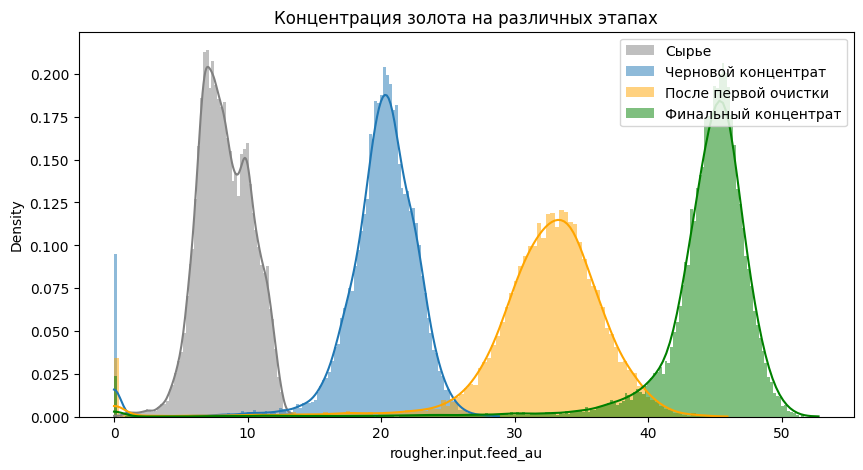

In [26]:
# золото
plt.figure(figsize=(10, 5))
sns.histplot(full_data['rougher.input.feed_au'], 
             label='Сырье', kde=True, stat="density", 
             linewidth=0, color='grey')
sns.histplot(full_data['rougher.output.concentrate_au'], 
             label='Черновой концентрат', kde=True, stat="density", linewidth=0)
sns.histplot(full_data['primary_cleaner.output.concentrate_au'], 
             label='После первой очистки', kde=True, stat="density", 
             linewidth=0, color='orange')
sns.histplot(full_data['final.output.concentrate_au'], 
             label='Финальный концентрат', kde=True, stat="density", 
             linewidth=0, color='green')
plt.title('Концентрация золота на различных этапах')
plt.legend()
plt.show();

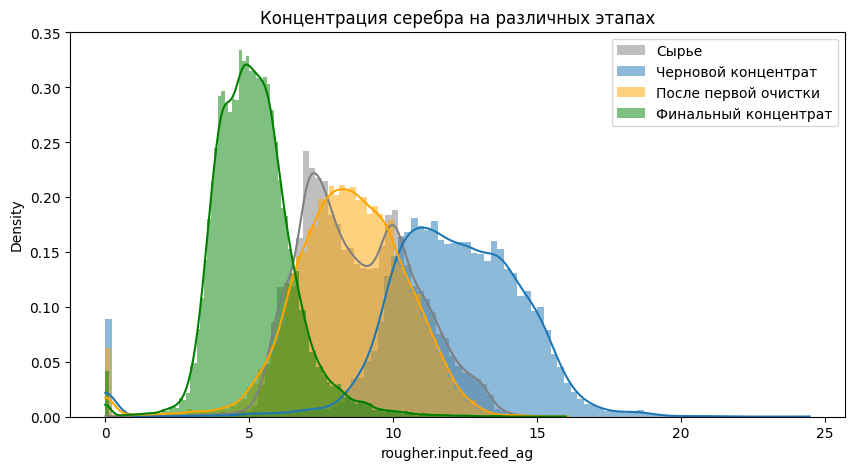

In [27]:
# серебро
plt.figure(figsize=(10, 5))
sns.histplot(full_data['rougher.input.feed_ag'], 
             label='Сырье', kde=True, stat="density", 
             linewidth=0, color='grey')
sns.histplot(full_data['rougher.output.concentrate_ag'], 
             label='Черновой концентрат', kde=True, stat="density", linewidth=0)
sns.histplot(full_data['primary_cleaner.output.concentrate_ag'], 
             label='После первой очистки', kde=True, stat="density", 
             linewidth=0, color='orange')
sns.histplot(full_data['final.output.concentrate_ag'], 
             label='Финальный концентрат', kde=True, stat="density", 
             linewidth=0, color='green')
plt.title('Концентрация серебра на различных этапах')
plt.legend()
plt.show();

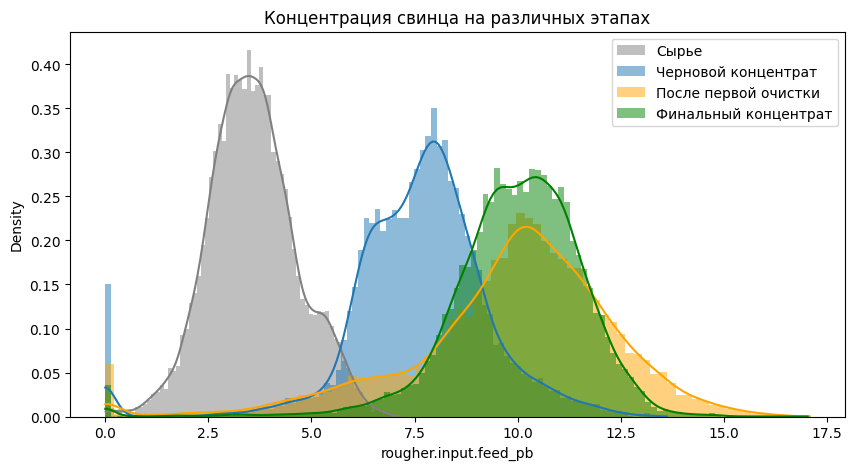

In [28]:
# свинец
plt.figure(figsize=(10, 5))
sns.histplot(full_data['rougher.input.feed_pb'], 
             label='Сырье', kde=True, stat="density", 
             linewidth=0, color='grey')
sns.histplot(full_data['rougher.output.concentrate_pb'], 
             label='Черновой концентрат', kde=True, stat="density", linewidth=0)
sns.histplot(full_data['primary_cleaner.output.concentrate_pb'], 
             label='После первой очистки', kde=True, stat="density", 
             linewidth=0, color='orange')
sns.histplot(full_data['final.output.concentrate_pb'], 
             label='Финальный концентрат', kde=True, stat="density", 
             linewidth=0, color='green')
plt.title('Концентрация свинца на различных этапах')
plt.legend()
plt.show();

**Вывод:** Концентрация золота постепенно возрастает на каждом этапе очистки. У серебра и свинца картина другая. Концентрация свинца на финальном этапе очистки не сильно отличается от значения на предыдущем этапе, а концентрация серебра на финальной стадии меньше сырья. На графиках заметно незначительное количество выбросов в районе нуля. 

In [29]:
old_data = full_data.copy()
full_data = full_data.loc[full_data['final.output.concentrate_au']>0]
full_data = full_data.loc[full_data['final.output.concentrate_ag']>0]
full_data = full_data.loc[full_data['final.output.concentrate_pb']>0]
full_data = full_data.loc[full_data['primary_cleaner.output.concentrate_au']>0]
full_data = full_data.loc[full_data['primary_cleaner.output.concentrate_ag']>0]
full_data = full_data.loc[full_data['primary_cleaner.output.concentrate_pb']>0]
full_data = full_data.loc[full_data['rougher.output.concentrate_au']>0]
full_data = full_data.loc[full_data['rougher.output.concentrate_ag']>0]
full_data = full_data.loc[full_data['rougher.output.concentrate_pb']>0]
full_data = full_data.loc[full_data['rougher.input.feed_au']>0]
full_data = full_data.loc[full_data['rougher.input.feed_ag']>0]
full_data = full_data.loc[full_data['rougher.input.feed_pb']>0]

print('Процент удаленных данных : {:,.2%}'.format((len(old_data) - len(full_data)) / len(old_data)))
full_data.info()

Процент удаленных данных : 3.07%
<class 'pandas.core.frame.DataFrame'>
Index: 18842 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               18842 non-null  float64
 1   rougher.input.feed_ag                               18842 non-null  float64
 2   rougher.input.feed_pb                               18842 non-null  float64
 3   rougher.input.feed_sol                              18842 non-null  float64
 4   rougher.input.feed_rate                             18842 non-null  float64
 5   rougher.input.feed_size                             18842 non-null  float64
 6   rougher.input.floatbank10_sulfate                   18842 non-null  float64
 7   rougher.input.floatbank10_xanthate                  18842 non-null  float64
 8   rougher.state.fl

In [30]:
train = pd.merge(full_data, train, how='inner', indicator=True) \
          .query("_merge == 'both'") \
          .drop('_merge', axis=1)

train = train[test.columns]
train.shape

(13982, 54)

### Размеры гранул

Сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках. 

Н0 : Распределения в выборках **равны**.

Н1 : Распределения в выборках **различны**.

In [31]:
results = st.ttest_ind(train['rougher.input.feed_size'], test['rougher.input.feed_size'])

alpha = 0.05

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.9233782195495766
Не получилось отвергнуть нулевую гипотезу


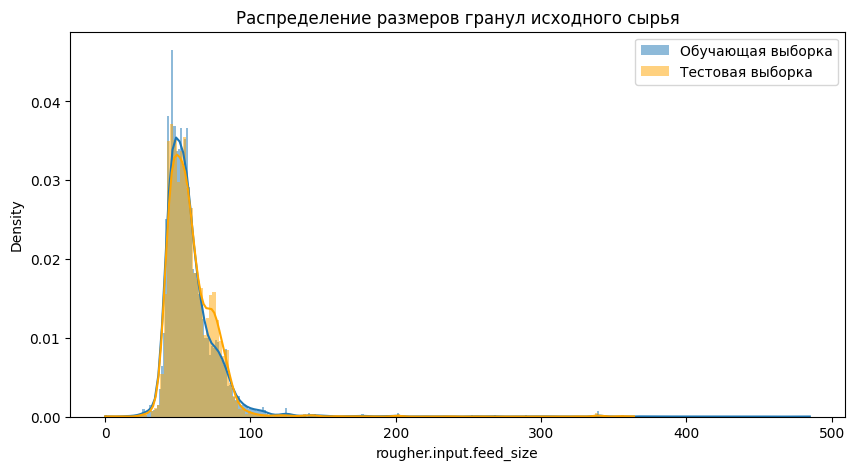

In [32]:
plt.figure(figsize=(10,5))
sns.histplot(train['rougher.input.feed_size'], 
             label='Обучающая выборка', kde=True, stat="density", 
             linewidth=0)
sns.histplot(test['rougher.input.feed_size'], 
             label='Тестовая выборка', color='orange', kde=True, 
             stat="density", linewidth=0)
plt.title('Распределение размеров гранул исходного сырья')
plt.legend()
plt.show();

**Вывод:** Размеры гранул исходного сырья в обеих выборках совпадают.

### Суммарная концентрация металлов

Исследуем суммарную концентрацию металлов на разных стадиях

In [33]:
feed_sum = (full_data['rougher.input.feed_au'] + 
            full_data['rougher.input.feed_pb'] +
            full_data['rougher.input.feed_ag'])

black_sum = (full_data['rougher.output.concentrate_au'] + 
             full_data['rougher.output.concentrate_pb'] + 
             full_data['rougher.output.concentrate_ag'])

after_first_sum = (full_data['primary_cleaner.output.concentrate_au'] + 
                   full_data['primary_cleaner.output.concentrate_ag'] + 
                   full_data['primary_cleaner.output.concentrate_pb'])

final_sum = (full_data['final.output.concentrate_pb'] + 
             full_data['final.output.concentrate_au'] + 
             full_data['final.output.concentrate_ag'])

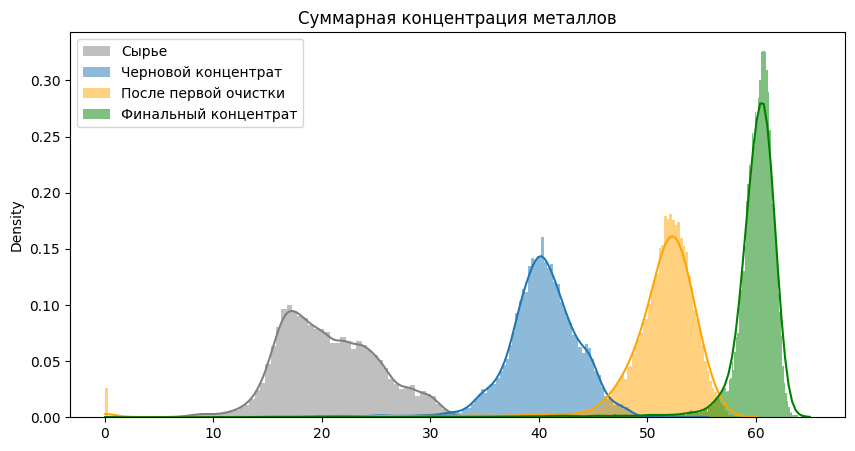

In [34]:
plt.figure(figsize=(10, 5))
sns.histplot(feed_sum, label='Сырье', kde=True, stat="density", 
             linewidth=0, color='grey')
sns.histplot(black_sum, label='Черновой концентрат', 
             kde=True, stat="density", linewidth=0)
sns.histplot(after_first_sum, label='После первой очистки', 
             kde=True, stat="density", linewidth=0, color='orange')
sns.histplot(final_sum, label='Финальный концентрат', 
             kde=True, stat="density", linewidth=0, color='green')
plt.title('Суммарная концентрация металлов')
plt.legend()
plt.show();

**Вывод:** Суммарная концентрация металлов возрастает с каждой стадией очистки

**Вывод:** Рассмотрели концентрацию металлов на разных этапах очистки и определили закономерности. Подтвердили соответсвие размеров гранул сырья в обучающей и тестовой выборках. Провели исследование суммарной концентрации металлов на разных этапах очистки. Были обнаружены и удалены аномалии.

## Модель

* Напишем функцию для вычисления итоговой sMAPE.
* Обучим модели решающего дерева, случайного леса и линеной регрессии. Оценим их качество кросс-валидацией.
* Проверим лучшую модель на тестовой выборке

In [62]:
# функция для sMAPE
def smape(target, prediction):
    a = np.abs(target-prediction)
    b = (np.abs(target)+np.abs(prediction)) / 2
    n = len(target)
    return 1/n * np.sum(a / b) * 100 

In [36]:
# создадим scorer для кросс-валидации
smape_scorer = make_scorer(smape, greater_is_better=False)

In [69]:
# итоговое sMAPE
def final_smape(smape1, smape2):
    return 0.25 * smape1 + 0.75 * smape2

### Признаки для обучения моделей

In [38]:
# выделим признаки
target_train_rougher = train['rougher.output.recovery']
target_test_rougher = test['rougher.output.recovery']
target_train_final = train['final.output.recovery']
target_test_final = test['final.output.recovery']

features_train = train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_test = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

print(target_train_rougher.shape, target_train_final.shape, features_train.shape)
print(target_test_rougher.shape, target_test_final.shape, features_test.shape)

(13982,) (13982,) (13982, 52)
(4860,) (4860,) (4860, 52)


In [39]:
# масштабирование
pd.options.mode.chained_assignment = None

numeric = list(features_train.columns)

# создадим объект структуры StandardScaler и настроим его на обучающих данных
scaler = MinMaxScaler()
scaler.fit(features_train[numeric])

# преобразуем выборки
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

features_train.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,0.471977,0.417549,0.323034,0.688270,0.729671,0.114323,0.331850,0.619138,0.661060,0.660854,...,0.465432,0.536120,0.503998,0.373418,0.233603,0.540868,0.275626,0.452465,0.441013,0.297042
1,0.471425,0.421713,0.320353,0.668534,0.732102,0.118019,0.331423,0.618909,0.661443,0.671271,...,0.464617,0.530683,0.497775,0.377685,0.236180,0.537504,0.272162,0.452297,0.436272,0.305862
2,0.462945,0.418651,0.305243,0.672616,0.738703,0.118497,0.330022,0.638657,0.661069,0.671248,...,0.465372,0.536061,0.496202,0.377935,0.236899,0.537578,0.273225,0.452395,0.437212,0.303473
3,0.445160,0.413636,0.287946,0.689274,0.756213,0.119079,0.321979,0.639254,0.661132,0.670919,...,0.466086,0.539061,0.499816,0.377859,0.234618,0.539256,0.271891,0.452790,0.436495,0.305558
4,0.412038,0.414843,0.252314,0.642242,0.753344,0.115479,0.303363,0.638806,0.661042,0.672084,...,0.465780,0.540898,0.497880,0.378036,0.233605,0.534761,0.268858,0.452639,0.436219,0.303372


### Обучение. Rougher

In [40]:
# решающее дерево
param_grid = {'max_depth': range(2, 7)}

model = DecisionTreeRegressor(random_state=12345)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
grid_search.fit(features_train, target_train_rougher)
smape_rougher_tree = -grid_search.best_score_
print('Лучшее значение sMAPE : {} при : {}'
      .format(-grid_search.best_score_, grid_search.best_params_))

Лучшее значение sMAPE : 6.6906237877769 при : {'max_depth': 6}


In [41]:
# случайный лес
param_grid = {'max_depth' : range(2, 7), 
              'n_estimators': range(10, 31, 10)}

model = RandomForestRegressor(random_state=12345)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer, verbose=2)
grid_search.fit(features_train, target_train_rougher)
smape_rougher_forest = -grid_search.best_score_
print('Лучшее значение sMAPE : {} при : {}'
      .format(-grid_search.best_score_, grid_search.best_params_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=30; total time=   1.8s
[CV] END .......................max_depth=2, n_e

In [42]:
# линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train_rougher)
smape = cross_val_score(model, features_train, target_train_rougher, cv=5, scoring=smape_scorer)
final_score_rougher = smape.mean() *-1
print('Лучшее значение sMAPE :', final_score_rougher)

Лучшее значение sMAPE : 7.033526267625992


### Обучение. Final

In [43]:
# решающее дерево
param_grid = {'max_depth': range(2, 7)}

model = DecisionTreeRegressor(random_state=12345)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
grid_search.fit(features_train, target_train_final)
smape_final_tree = -grid_search.best_score_
print('Лучшее значение sMAPE : {} при : {}'
      .format(-grid_search.best_score_, grid_search.best_params_))

Лучшее значение sMAPE : 9.211340584742235 при : {'max_depth': 3}


In [44]:
# случайный лес
param_grid = {'max_depth' : range(2, 7), 
              'n_estimators': range(10, 31, 10)}

model = RandomForestRegressor(random_state=12345)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer, verbose=2)
grid_search.fit(features_train, target_train_final)
smape_final_forest = -grid_search.best_score_
print('Лучшее значение sMAPE : {} при : {}'
      .format(-grid_search.best_score_, grid_search.best_params_))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=20; total time=   1.2s
[CV] END .......................max_depth=2, n_estimators=30; total time=   1.9s
[CV] END .......................max_depth=2, n_e

In [45]:
# линейная регрессия
model = LinearRegression()
model.fit(features_train, target_train_final)
smape = cross_val_score(model, features_train, target_train_final, cv=5, scoring=smape_scorer)
final_score_final = smape.mean() *-1
print('Лучшее значение sMAPE :', final_score_final)

Лучшее значение sMAPE : 9.477249908910009


In [46]:
# итоговый sMAPE для дерева решений
final_smape = final_smape(smape_rougher_tree, smape_final_tree)
print('Итоговый sMAPE :', final_smape)

Итоговый sMAPE : 8.581161385500902


In [53]:
# итоговый sMAPE для случайного леса
final_smape = final_smape(smape_rougher_forest, smape_final_forest)
print('Итоговый sMAPE :', final_smape)

Итоговый sMAPE : 8.268801174990356


In [60]:
# итоговый sMAPE для линейной регрессии
final_smape = final_smape(final_score_rougher, final_score_final)
print('Итоговый sMAPE :', final_smape)

Итоговый sMAPE : 8.866318998589005


**Вывод:** Лучшие показатель у модели случайного леса. Гипперпараметры для rougher - глубина 5, количества деревьев 20. Гипперпараметры для final - глубина 2, количесво деревьев 20. Итоговый sMAPE = 8,27.

### Проверка лучшей модели

In [63]:
# rougher
model = RandomForestRegressor(max_depth=5, n_estimators=20, random_state=12345) 
model.fit(features_train, target_train_rougher)
predictions_test = model.predict(features_test)
smape_rougher = smape(target_test_rougher, predictions_test)

print('sMAPE тестовой выборки :', smape_rougher)

sMAPE тестовой выборки : 3.969309656916795


In [64]:
# final
model = RandomForestRegressor(max_depth=2, n_estimators=20, random_state=12345) 
model.fit(features_train, target_train_final)
predictions_test = model.predict(features_test)
smape_final = smape(target_test_final, predictions_test)

print('sMAPE тестовой выборки :', smape_final)

sMAPE тестовой выборки : 8.493110552430466


In [67]:
# подсчет итогового sMAPE
final_smape = final_smape(smape_rougher, smape_final)
print('Итоговый sMAPE :', final_smape)

Итоговый sMAPE : 7.362160328552048


In [70]:
# проверка на адекватность модели
d_rougher = DummyRegressor(strategy='mean')
d_rougher.fit(features_train, target_train_rougher)
d_predicted_rougher = d_rougher.predict(features_test)
d_smape_rougher = smape(target_test_rougher, d_predicted_rougher)
d_rougher_score = d_smape_rougher.mean()

d_final = DummyRegressor(strategy='mean')
d_final.fit(features_train, target_train_final)
d_predicted_final = d_final.predict(features_test)
d_smape_final = smape(target_test_final, d_predicted_final)
d_final_score = d_smape_final.mean()

d_results = final_smape(d_rougher_score, d_final_score)
d_results

8.471903961218088

## Общий вывод

* Была проведена предобработка данных, проверена формула вычисления эффективности обогощения, соотнесены признаки в обучающей и тестовой выборках.
* Проведен исследовательский анализ данных: исследовано изменение концентрации металлов на каждом этапе очистки (сырье, в черновом концентрате, после первой очистки и на финальной стадии), проведен анализ рамера гранул в обучающей и тестовой выборках, исследованы суммарные концентрации металлов.
* Были обучены модели решающего дерева, случайного леса и линейной регрессии, для первых двух подобраны лучшие гипперпараметры. Подсчитана метрика sMAPE - симметричное среднее абсолютное процентное отклонение. Выбрана лучшая модель - модель случаного леса.
* Подсчитана итоговая метрика sMAPE равная 8,26.